In [21]:
# =============================================================================
# Cell 1: Configuration & Setup
# =============================================================================
# This cell contains all user settings. Modify the file paths and
# parameters below to match your analysis needs.
# =============================================================================

# --- 1. File Paths ---
# Provide the full paths to your three imputed datasets.
LENIENT_FILE = "/PATH/TO/YOUR/LENIENT/THRESHOLD.xlsx"
MODERATE_FILE = "/PATH/TO/YOUR/MODERATE/THRESHOLD.xlsx"
STRICT_FILE = "/PATH/TO/YOUR/STRICT/THRESHOLD.xlsx"

# Where to save the output PNG file.
OUTPUT_FILE_PATH = "/PATH/TO/YOUR/OUTPUT"


# --- 2. Analysis Parameters ---

# 2a. Timepoint Selection
# To analyze a specific timepoint, enter its identifier (e.g., '3' for 2h).
# To analyze the entire timecourse, set this to None.
TIMEPOINT_TO_ANALYZE = '3' # Options: None, '1', '2', '3', '4', '5'

# 2b. Number of Top Metabolites
TOP_N_METABOLITES = 15

# 2c. Metabolite Exclusion
# List any metabolites to remove (e.g., contaminants). Matching is case-insensitive.
METABOLITES_TO_EXCLUDE = [
    '9-methylanthracene'
]

# 2d. Sample Exclusion
# <<< NEW: List the exact column names of any samples to remove from all analyses. >>>
SAMPLES_TO_EXCLUDE = [
    'TM2An4_2', 'TM2An4_2', 'TM2A5_1', 'TM2A4_4' 
]


# --- 3. Sample & Timepoint Configuration ---

# 3a. Sample Naming Patterns
SAMPLE_NAMING_PATTERNS = [
    (r'TM2A(?P<timepoint>\d+)_', '+ GFP'),
    (r'TM2An(?P<timepoint>\d+)_', '- GFP')
]

# 3b. Timepoint Mapping
TIMEPOINT_MAP = { '1': '0h', '2': '0.5h', '3': '2h', '4': '5h', '5': '10h' }


# --- 4. Imports and Environment Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import re
import warnings

warnings.filterwarnings('ignore')
plt.style.use('default')

print("--- Configuration and Setup Complete ---")

--- Configuration and Setup Complete ---



>>> INITIATING THRESHOLD CONCORDANCE ANALYSIS <<<
Loading and preprocessing: LEN_RF_Imputed.xlsx
  -> Removed 1 metabolite(s).
Loading and preprocessing: MOD_RF_Imputed.xlsx
  -> Removed 1 metabolite(s).
Loading and preprocessing: STR_RF_Imputed.xlsx
  -> Removed 1 metabolite(s).
  -> Successfully removed 3 sample(s) from metadata.

--- Metadata Summary ---
Samples found per timepoint ID:
timepoint_id
1    10
2    10
3    10
4     8
5     9
Name: count, dtype: int64
------------------------

Filtering analysis for 10 samples from timepoint '3'.


Found 45 unique top metabolites across all thresholds.
Generating heatmap...


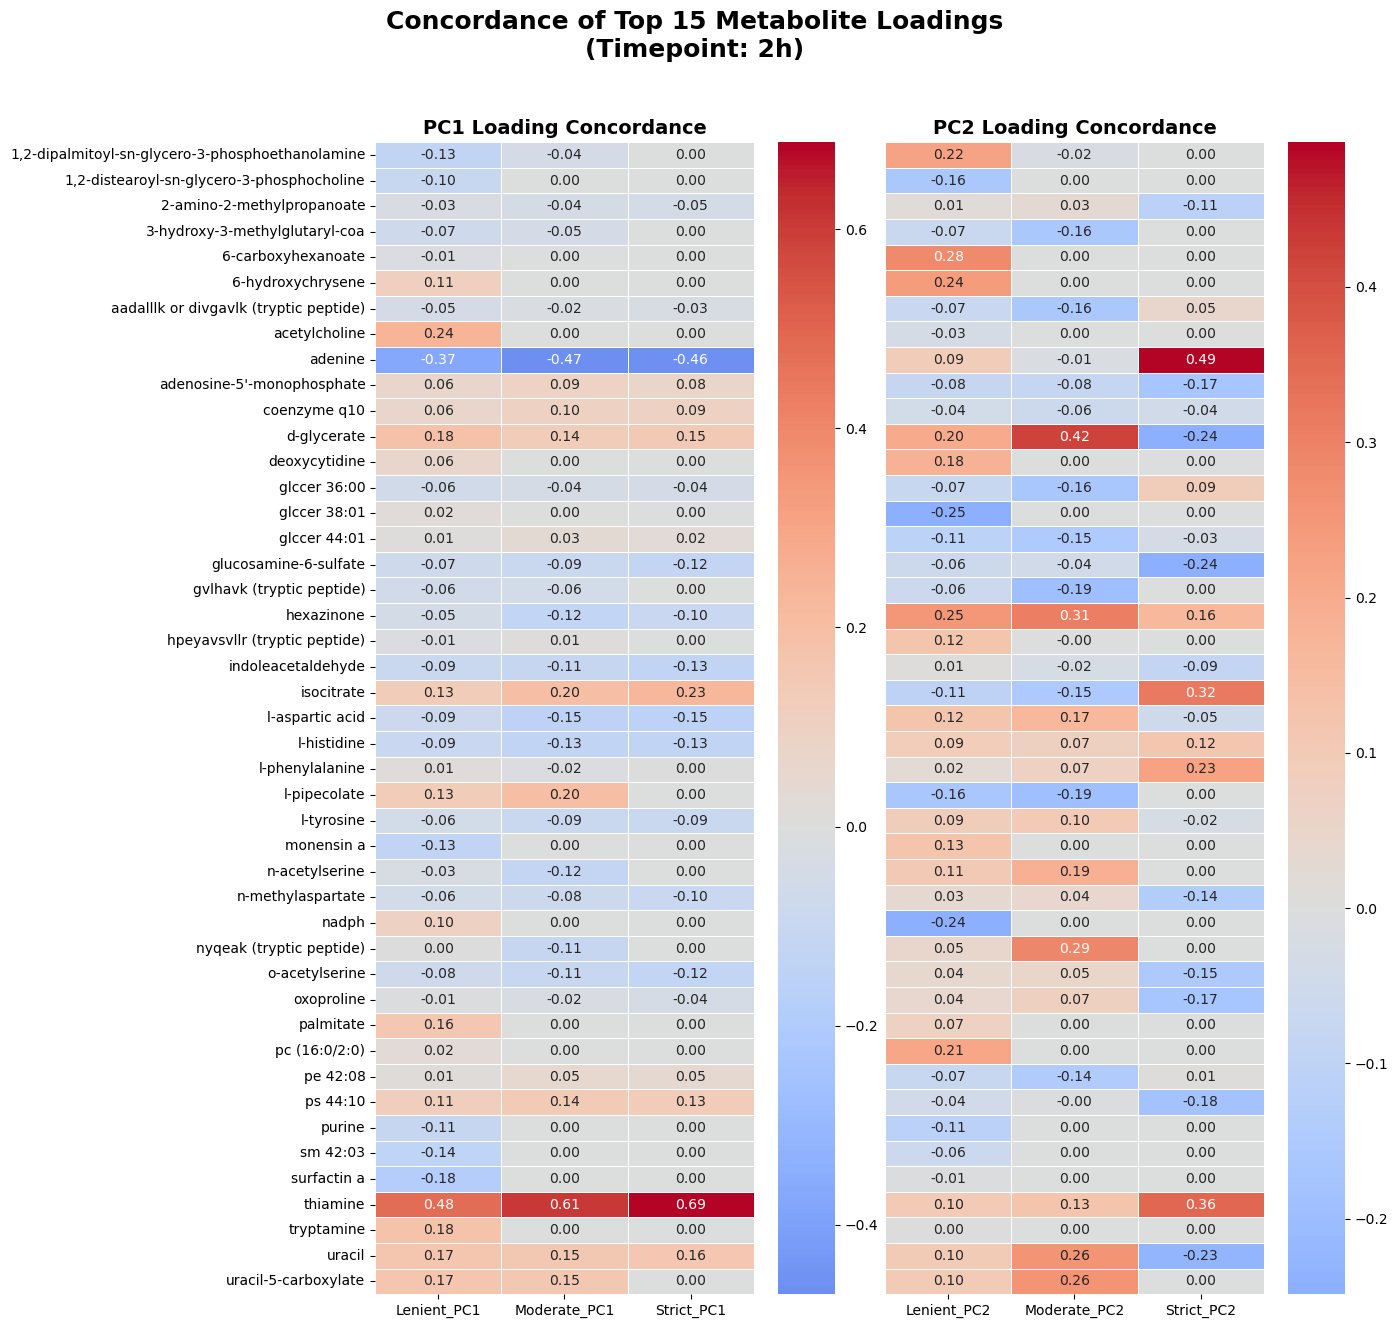


Heatmap saved to: /users/aranpurdy/desktop/GIT2/X_3Threshold_Concordance.png

--- Loading Vector Correlations ---

PC1 Correlations:
              Lenient_PC1  Moderate_PC1  Strict_PC1
Lenient_PC1      1.000000      0.816346    0.781492
Moderate_PC1     0.816346      1.000000    0.941939
Strict_PC1       0.781492      0.941939    1.000000

PC2 Correlations:
              Lenient_PC2  Moderate_PC2  Strict_PC2
Lenient_PC2      1.000000      0.533273    0.045300
Moderate_PC2     0.533273      1.000000   -0.149406
Strict_PC2       0.045300     -0.149406    1.000000

--- Analysis Complete! ---


In [22]:
# =============================================================================
# Cell 2: Analysis Pipeline
# =============================================================================
# This cell contains all functions and the execution logic.
# Do not modify this cell. Run it after setting your parameters in Cell 1.
# =============================================================================

# --- A. Data Loading and Pretreatment Functions ---

def load_and_preprocess(filepath, exclude_metabolites=None):
    """Loads, filters metabolites, and applies Pareto scaling."""
    print(f"Loading and preprocessing: {filepath.split('/')[-1]}")
    try:
        df = pd.read_excel(filepath, index_col=0)
        df.index = df.index.str.strip().str.lower()
    except FileNotFoundError:
        print(f"ERROR: File not found at {filepath}.")
        return None

    if exclude_metabolites:
        exclude_metabolites_lower = [item.lower().strip() for item in exclude_metabolites]
        initial_met_count = df.shape[0]
        df = df.drop(index=exclude_metabolites_lower, errors='ignore')
        if initial_met_count - df.shape[0] > 0:
            print(f"  -> Removed {initial_met_count - df.shape[0]} metabolite(s).")

    # Pareto scaling
    mean_vals = df.mean(axis=1)
    std_vals = df.std(axis=1, ddof=1).replace(0, 1)
    scaled_df = df.sub(mean_vals, axis=0).div(np.sqrt(std_vals), axis=0)
    return scaled_df.replace([np.inf, -np.inf], 0).fillna(0)

def create_metadata_table(columns, exclude_samples=None):
    """Parses sample names to create a metadata table and removes excluded samples."""
    metadata_list = []
    for sample_name in columns:
        timepoint_id, condition = "Unknown", "Unknown"
        for pattern, cond_name in SAMPLE_NAMING_PATTERNS:
            match = re.search(pattern, sample_name)
            if match:
                try:
                    timepoint_id = match.group('timepoint')
                    condition = cond_name
                    break
                except IndexError:
                    pass
        metadata_list.append({
            'sample': sample_name,
            'timepoint_id': timepoint_id,
            'timepoint_label': TIMEPOINT_MAP.get(timepoint_id, "Unknown"),
            'condition': condition
        })
    
    metadata_df = pd.DataFrame(metadata_list)
    
    # <<< FIX: Ensure the timepoint_id column is treated as a string to prevent type errors. >>>
    metadata_df['timepoint_id'] = metadata_df['timepoint_id'].astype(str)
    
    if exclude_samples:
        initial_count = len(metadata_df)
        metadata_df = metadata_df[~metadata_df['sample'].isin(exclude_samples)]
        removed_count = initial_count - len(metadata_df)
        if removed_count > 0:
            print(f"  -> Successfully removed {removed_count} sample(s) from metadata.")
            
    return metadata_df

def run_pca(data):
    """Performs PCA on a given data matrix."""
    if data.shape[1] < 2: 
        print("Warning: Not enough samples for PCA.")
        return None
    pca = PCA(n_components=2)
    pca.fit(data.T)
    loadings_df = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=data.index)
    return loadings_df


# --- B. Main Execution Block ---

print("\n>>> INITIATING THRESHOLD CONCORDANCE ANALYSIS <<<")

data_files = {'Lenient': LENIENT_FILE, 'Moderate': MODERATE_FILE, 'Strict': STRICT_FILE}
preprocessed_data = {name: load_and_preprocess(fp, METABOLITES_TO_EXCLUDE) for name, fp in data_files.items()}
preprocessed_data = {k: v for k, v in preprocessed_data.items() if v is not None}

if len(preprocessed_data) < 2:
    print("\nAnalysis halted: At least two valid data files are required.")
else:
    master_metadata = create_metadata_table(list(preprocessed_data.values())[0].columns, SAMPLES_TO_EXCLUDE)
    print("\n--- Metadata Summary ---")
    print("Samples found per timepoint ID:")
    print(master_metadata['timepoint_id'].value_counts().sort_index())
    print("------------------------")

    samples_to_analyze = master_metadata['sample'].tolist()
    analysis_title = "Full Timecourse"
    if TIMEPOINT_TO_ANALYZE:
        # <<< FIX: Now correctly compares string-to-string and provides a better error message. >>>
        if TIMEPOINT_TO_ANALYZE in master_metadata['timepoint_id'].unique():
            samples_to_analyze = master_metadata[master_metadata['timepoint_id'] == TIMEPOINT_TO_ANALYZE]['sample'].tolist()
            analysis_title = f"Timepoint: {TIMEPOINT_MAP.get(TIMEPOINT_TO_ANALYZE, TIMEPOINT_TO_ANALYZE)}"
            print(f"\nFiltering analysis for {len(samples_to_analyze)} samples from timepoint '{TIMEPOINT_TO_ANALYZE}'.\n")
        else:
            print(f"\nERROR: Timepoint ID '{TIMEPOINT_TO_ANALYZE}' not found.")
            print(f"Available timepoint IDs are: {list(master_metadata['timepoint_id'].unique())}")
            print("Please check the 'TIMEPOINT_TO_ANALYZE' variable in Cell 1. Halting.")
            preprocessed_data = {}

    all_loadings = {name: run_pca(df[samples_to_analyze]) for name, df in preprocessed_data.items()}
    all_loadings = {k: v for k, v in all_loadings.items() if v is not None}

    if not all_loadings:
        print("\nAnalysis halted: PCA could not be performed for the specified scope.")
    else:
        top_metabolites = set()
        for name, loadings_df in all_loadings.items():
            top_metabolites.update(loadings_df['PC1'].abs().nlargest(TOP_N_METABOLITES).index)
            top_metabolites.update(loadings_df['PC2'].abs().nlargest(TOP_N_METABOLITES).index)
        
        master_list = sorted(list(top_metabolites))
        print(f"\nFound {len(master_list)} unique top metabolites across all thresholds.")

        concordance_df = pd.DataFrame(index=master_list)
        for name, loadings_df in all_loadings.items():
            concordance_df[f'{name}_PC1'] = loadings_df['PC1'].reindex(master_list).fillna(0)
            concordance_df[f'{name}_PC2'] = loadings_df['PC2'].reindex(master_list).fillna(0)

        print("Generating heatmap...")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, max(10, len(master_list) * 0.3)))
        
        sns.heatmap(concordance_df[[c for c in concordance_df if 'PC1' in c]], ax=ax1, cmap='coolwarm', center=0, annot=True, fmt=".2f", linewidths=.5)
        ax1.set_title('PC1 Loading Concordance', fontsize=14, fontweight='bold'); ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

        sns.heatmap(concordance_df[[c for c in concordance_df if 'PC2' in c]], ax=ax2, cmap='coolwarm', center=0, annot=True, fmt=".2f", linewidths=.5)
        ax2.set_title('PC2 Loading Concordance', fontsize=14, fontweight='bold'); ax2.set_yticks([])

        fig.suptitle(f'Concordance of Top {TOP_N_METABOLITES} Metabolite Loadings\n({analysis_title})', fontsize=18, fontweight='bold')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.savefig(OUTPUT_FILE_PATH, dpi=300, bbox_inches='tight'); plt.show()
        print(f"\nHeatmap saved to: {OUTPUT_FILE_PATH}")

        print("\n--- Loading Vector Correlations ---")
        print("\nPC1 Correlations:"); print(concordance_df[[c for c in concordance_df if 'PC1' in c]].corr())
        print("\nPC2 Correlations:"); print(concordance_df[[c for c in concordance_df if 'PC2' in c]].corr())
        print("\n--- Analysis Complete! ---")